# Spotify NB 4 - regression
# Set up

In [27]:
%reset -fs

In [28]:
import pandas as pd
import numpy as np
import json
import math

from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import StackingRegressor

import sklearn as skl
import sklearn.linear_model as skl_lm
import sklearn.ensemble as skl_e
import sklearn.metrics as skl_m
import sklearn.feature_selection as skl_fs
import sklearn.cluster as skl_c
import sklearn.preprocessing as skl_p
import sklearn.model_selection as skl_ms

import xgboost as xgb
import statsmodels.api as sm
from patsy import dmatrices
import scipy.stats as ss
from statsmodels.stats.outliers_influence import variance_inflation_factor

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.metrics import mean_absolute_error 
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

%matplotlib inline
plt.style.use('seaborn')
RSEED=np.random.seed(42)

sns.set(style="whitegrid", palette="viridis", color_codes=True)

## Data cleaning & feature engineering
The data was cleaned in the course of the EDA. Additional features were created and the new dataset was saved to a csv, that will be the starting point for this notebook. For further information on the data cleaning please refer to the respective notebook (Spotify_2019_EDA).

In [29]:
data = pd.read_csv('data/tracks_2019_cleaned.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)

In [60]:
df=data.copy()#.sample(frac=.3, random_state=RSEED)
df.shape

(104360, 28)

## Assigning train and test data

In [61]:
y = df['popularity']
X = df.drop(y.name, axis=1)
X_train, X_test, y_train, y_test = skl_ms.train_test_split(X, y, test_size=0.3, random_state=RSEED)

## Displaying results

In [32]:
def show_regression_results(preprocessor, model, X, y):
    
    X_preprocessed = preprocessor.transform(X)
    y_predicted = model.predict(X_preprocessed)
    
    # calculating and printing scores
    print('MSE :\n{:.2f}'.format(
        skl_m.mean_squared_error(y, y_predicted))),
    print("RMSE:\n{:.2f}".format(
        skl_m.mean_squared_error(y, y_predicted, squared=False))),
    print("R2:\n{:.2f}".format(skl_m.r2_score(y, y_predicted))),
    print("MAE:\n{:.2f}".format(
        skl_m.median_absolute_error(y, y_predicted)))

# Baseline model - linear regression

## Preprocessing

In [33]:
# Defining categorical features for preprocessing
categoric_features = list(X.columns[X.dtypes == object])+ list(X.columns[X.dtypes == bool])
exclude = ['album', 'artists', 'artists_id', 'available_markets','cover_url', 'name',
           'preview_url', 'release_date', 'track_id', 'genres']
categoric_features = [x for x in categoric_features if x not in exclude]
categoric_features

['main_genres']

In [34]:
# Defining numerical features for preprocessing
numeric_features = list(X.columns[X.dtypes!=object])
exclude = list(X.columns[X.dtypes == bool])
numeric_features = [x for x in numeric_features if x not in exclude]
numeric_features

['acousticness',
 'album_track_no',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'time_signature',
 'total_album_tracks',
 'place_in_album',
 'month',
 'no_genres']

In [35]:
# Creating transforming pipes to preprocess both categorical and numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', skl_p.StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', skl_p.OneHotEncoder(drop='first'))])

# Combining the preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categoric_features)
    ])

## Model

In [36]:
# Creating a pipe with the preprocessor and the baseline model
base_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('linreg', skl_lm.LinearRegression(n_jobs=-1))
     ])

base_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['acousticness',
                                                   'album_track_no',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'explicit',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
  

### Performance on train data

In [37]:
show_regression_results(base_pipe['preprocessor'], base_pipe['linreg'], X_train, y_train)

MSE :
153.18
RMSE:
12.38
R2:
0.33
MAE:
6.70


### Performance on test data

In [38]:
show_regression_results(base_pipe['preprocessor'], base_pipe['linreg'], X_test, y_test)

MSE :
150.98
RMSE:
12.29
R2:
0.33
MAE:
6.67


# Predictive modeling

## Feature selection - test for multicolliniarity

The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone. A VIF between 5-10 indicates multicolinearity is likely present and you should consider dropping the variable. (https://etav.github.io/python/vif_factor_python.html)

In [39]:
#Gathering features
features = "+".join(numeric_features+categoric_features)
y1, X1 = dmatrices('popularity ~' + features, X.join(y), return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif["features"] = X1.columns
vif.round(1)

,VIF Factor,features
0,1105.6,Intercept
1,5.1,main_genres[T.classical]
2,3.3,main_genres[T.country]
3,3.4,main_genres[T.disco]
4,12.8,main_genres[T.electronic]
5,4.7,main_genres[T.funk]
6,30.7,main_genres[T.hiphop]
7,8.0,main_genres[T.house]
8,6.4,main_genres[T.jazz]
9,5.7,main_genres[T.latin]


The result shows a high VIF for some of the main genre dummies (possibly because of correlations with each other). Therefore, this feature will not be used in the ensuing regression. 

## Preprocessing

### Label

In [40]:
# Scaling the label using standard scaler
ss_y = skl_p.StandardScaler().fit(y_train.to_frame())
y_train_ss = ss_y.transform(y_train.to_frame())
y_test_ss = ss_y.transform(y_test.to_frame())

In [41]:
# Scaling the label using min-max scaler
mm_y = skl_p.MinMaxScaler().fit(y_train.to_frame())
y_train_mm = mm_y.transform(y_train.to_frame())
y_test_mm = mm_y.transform(y_test.to_frame())

In [42]:
# Scaling the label using box cox transformation 
pt_constant=0.01

#y_train_pt = ss.boxcox(y_train+pt_constant, 0)
y_train_pt = np.log(y_train+pt_constant)

pt_y = skl_p.PowerTransformer(method='box-cox').fit(y_train.to_frame()+pt_constant)
y_train_pt = pt_y.transform(y_train.to_frame()+pt_constant)
y_test_pt = pt_y.transform(y_test.to_frame()+pt_constant)

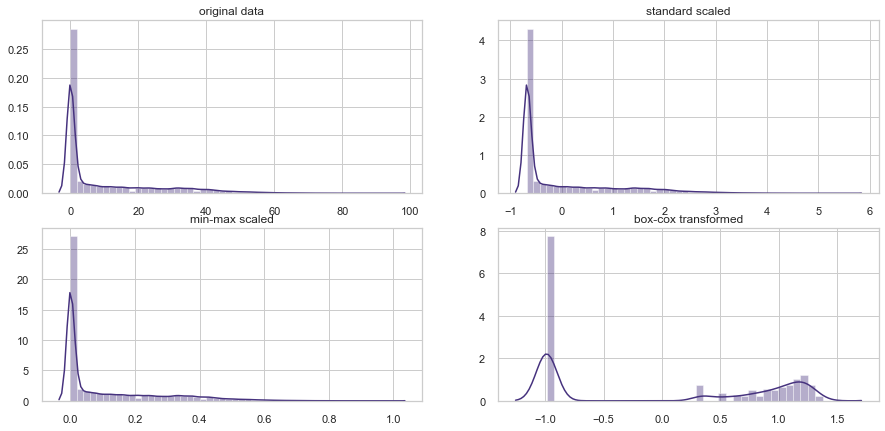

In [43]:
# Plotting the transformed data to compare it to the original data
f, axes = plt.subplots(2, 2, figsize=(15, 7), sharex=False)
sns.distplot(np.array(y_train), ax=axes[0,0]).set_title('original data');
sns.distplot(y_train_ss, ax=axes[0,1]).set_title('standard scaled');
sns.distplot(y_train_mm, ax=axes[1,0]).set_title('min-max scaled');
sns.distplot(y_train_pt, ax=axes[1,1]).set_title('box-cox transformed');

Due to the way the label data is skewed, conventional transformation models don't succeed to normalise it. Thus we'll proceed using the original data.

### Features

In [44]:
# Defining categorical features for preprocessing
categoric_features = list(X.columns[X.dtypes == object]) + list(
    X.columns[X.dtypes == bool])
exclude = ['album', 'artists', 'artists_id', 'available_markets', 'cover_url', 'name',
           'preview_url', 'release_date', 'track_id', 'genres', 'main_genres']
categoric_features = [x for x in categoric_features if x not in exclude]
categoric_features

[]

In [45]:
# Defining numerical features for preprocessing
numeric_features = list(X.columns[X.dtypes != object])
exclude = list(X.columns[X.dtypes == bool])
numeric_features = [x for x in numeric_features if x not in exclude]
numeric_features

['acousticness',
 'album_track_no',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'time_signature',
 'total_album_tracks',
 'place_in_album',
 'month',
 'no_genres']

In [46]:
# Creating transforming pipes to preprocess both categorical and numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', skl_p.StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', skl_p.OneHotEncoder(drop='first'))])

# Combining the preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categoric_features)
    ])

fitted_preprocessor=preprocessor.fit(X_train)

## Testing different models

In [47]:
# chosing models for testing
models={'linreg': skl_lm.LinearRegression(n_jobs=-1),
        'passive_aggressive' : skl_lm.PassiveAggressiveRegressor(random_state=RSEED),
        'ransac' : skl_lm.RANSACRegressor(random_state=RSEED),
        'elastic' : skl_lm.ElasticNet(random_state=RSEED),
        'stochastic_gradient_decent' : skl_lm.SGDRegressor(max_iter=1000, tol=1e-3, random_state=RSEED),
        'tree': tree.DecisionTreeRegressor(criterion = "mae", max_depth=3,random_state=RSEED),
        'ada_boost' : skl_e.AdaBoostRegressor(random_state=RSEED),
        'xgb' : xgb.XGBRegressor( n_jobs=-1)
       }

In [48]:
results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'R2', 'MAE'])
i = 0

for m in models.items():
    # Building a full pipeline with our preprocessor and a model
    pipe = Pipeline([('preprocessor', preprocessor), (m[0], m[1])])

    # Making predictions on the training set using cross validation
    y_train_predicted = skl_ms.cross_val_predict(pipe,
                                                 X_train,
                                                 y_train.ravel(),
                                                 cv=5,
                                                 verbose=5,
                                                 n_jobs=-1)

    # Calculating metrices
    temp = pd.DataFrame(
        {
            'Model': m[0],
            'MSE': skl_m.mean_squared_error(y_train, y_train_predicted),
            'RMSE': skl_m.mean_squared_error(y_train, y_train_predicted, squared = False),
            'R2' : skl_m.r2_score(y_train, y_train_predicted),
            'MAE': skl_m.median_absolute_error(y_train, y_train_predicted),
        },
        index=[i])
    i += 1

    results = pd.concat([results, temp])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

[02:18:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[02:18:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.5s remaining:    0.0s


[02:18:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.8s remaining:    0.0s


[02:18:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   37.2s remaining:    0.0s


[02:18:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   46.6s finished


In [49]:
results.round(2)

,Model,MSE,RMSE,R2,MAE
0,linreg,169.07,13.00,0.26,7.61
1,passive_aggressive,259.86,16.12,-0.14,9.32
2,ransac,395.39,19.88,-0.73,8.84
3,elastic,180.35,13.43,0.21,8.41
4,stochastic_gradient_decent,169.86,13.03,0.26,7.62
5,tree,190.85,13.81,0.16,1.00
6,ada_boost,205.21,14.33,0.10,12.42
7,xgb,138.51,11.77,0.39,6.03


Based on the results above we'll proceed with Linear Regression, Stochastic Gradient Decent, Decision Tree and XGBoost. We will first optimise the models where possible/ neccessary and then stack them in the final model.

## Stacked model

In [67]:
# make a prediction with a stacking ensemble

# defining the base models & chosing models based on outcome
level0 = [('linreg', skl_lm.LinearRegression(n_jobs=-1)),
          ('stochastic_gradient_decent', skl_lm.SGDRegressor(max_iter=1000, tol=1e-3, random_state=RSEED)),
          ('tree', tree.DecisionTreeRegressor(criterion = "mae", max_depth=3,random_state=RSEED)),
          ('XGB', xgb.XGBRegressor( n_jobs=-1))
           ]

# define meta learner model
level1 = skl_lm.LinearRegression()

# define the stacking ensemble
stack = StackingRegressor(estimators=level0, final_estimator=level1, cv=3, n_jobs=-1)

#build pipe
stacked_pipe =  Pipeline([
    ('preprocessor', preprocessor),
    ('stack', stack)])

scores = skl_ms.cross_val_score(stacked_pipe, X_train, y_train.values.ravel(), scoring='neg_median_absolute_error', cv=3, n_jobs=-1, verbose=5)


# make a prediction for one example
y_train_predicted = skl_ms.cross_val_predict(stacked_pipe, X_train, y_train.values.ravel(), cv=3, n_jobs=-1, verbose=5)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.2min finished


In [68]:
stacked_pipe.fit(X_train, y_train)
stacked_model = stacked_pipe['stack']
print("Cross-validation scores"+str(scores))

Cross-validation scores[-5.89787974 -5.88320379 -5.93883498]


### Performance on train data

In [69]:
show_regression_results(fitted_preprocessor, stacked_model, X_train, y_train)

MSE :
135.45
RMSE:
11.64
R2:
0.41
MAE:
5.90


### Performance on test data

In [70]:
show_regression_results(fitted_preprocessor, stacked_model, X_test, y_test)

MSE :
136.07
RMSE:
11.66
R2:
0.39
MAE:
5.98


## Feature Importance

[10:50:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
              features  importance
0            no_genres    0.461618
1       album_track_no    0.153866
2   total_album_tracks    0.106443
3             explicit    0.091671
4          duration_ms    0.046865
5          speechiness    0.024983
6     instrumentalness    0.024673
7             loudness    0.016184
8               energy    0.015546
9         acousticness    0.014518
10        danceability    0.012355
11               month    0.008626
12            liveness    0.006576
13               tempo    0.005612
14      time_signature    0.005435
15      place_in_album    0.005029


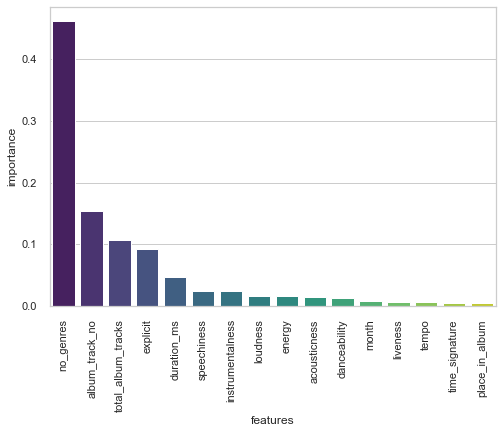

In [77]:
# model used for feature importances
pipe = Pipeline([('preprocessor', preprocessor), ('XGB', xgb.XGBRegressor(n_jobs=-1))])
pipe.fit(X_train, y_train)
XGB =pipe['XGB']

# feature importance
imp = pd.DataFrame([x for x in zip(numeric_features+categoric_features,XGB.feature_importances_)])
imp.columns = ['features', 'importance']
imp = imp.sort_values(['importance'], ascending=False).reset_index(drop=True)
print(imp)
# plot
chart=sns.barplot(x='features',y ='importance', data = imp, palette='viridis', order = imp['features'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=90);

# Neural network regression

## Model

In [82]:
X_train_preprocessed= fitted_preprocessor.transform(X_train)
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train_preprocessed.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 167,041
Trainable params: 167,041
Non-trainable params: 0
_________________________________________________________________


In [83]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [84]:
NN_model.fit(X_train_preprocessed, y_train, epochs=50, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 58441 samples, validate on 14611 samples
Epoch 1/50
58441/58441 [==============================] - 14s 246us/step - loss: 7.5714 - mean_absolute_error: 7.5714 - val_loss: 7.4444 - val_mean_absolute_error: 7.4444

Epoch 00001: val_loss improved from inf to 7.44444, saving model to Weights-001--7.44444.hdf5
Epoch 2/50
58441/58441 [==============================] - 13s 227us/step - loss: 7.3450 - mean_absolute_error: 7.3450 - val_loss: 7.4860 - val_mean_absolute_error: 7.4860

Epoch 00002: val_loss did not improve from 7.44444
Epoch 3/50
58441/58441 [==============================] - 13s 229us/step - loss: 7.2903 - mean_absolute_error: 7.2903 - val_loss: 7.3149 - val_mean_absolute_error: 7.3149

Epoch 00003: val_loss improved from 7.44444 to 7.31486, saving model to Weights-003--7.31486.hdf5
Epoch 4/50
58441/58441 [==============================] - 14s 236us/step - loss: 7.2358 - mean_absolute_error: 7.2358 - val_loss: 7.3079 - val_mean_absolute_error: 7.3079

Epoch 00004: val_lo

58441/58441 [==============================] - 13s 218us/step - loss: 6.1657 - mean_absolute_error: 6.1657 - val_loss: 7.5234 - val_mean_absolute_error: 7.5234

Epoch 00036: val_loss did not improve from 7.24545
Epoch 37/50
58441/58441 [==============================] - 13s 227us/step - loss: 6.1212 - mean_absolute_error: 6.1212 - val_loss: 7.7894 - val_mean_absolute_error: 7.7894

Epoch 00037: val_loss did not improve from 7.24545
Epoch 38/50
58441/58441 [==============================] - 13s 222us/step - loss: 6.0512 - mean_absolute_error: 6.0512 - val_loss: 7.5899 - val_mean_absolute_error: 7.5899

Epoch 00038: val_loss did not improve from 7.24545
Epoch 39/50
58441/58441 [==============================] - 13s 226us/step - loss: 6.0289 - mean_absolute_error: 6.0289 - val_loss: 7.7420 - val_mean_absolute_error: 7.7420

Epoch 00039: val_loss did not improve from 7.24545
Epoch 40/50
58441/58441 [==============================] - 13s 223us/step - loss: 5.9886 - mean_absolute_error: 5.98

In [85]:
# Load wights file of the best model :
wights_file = 'Weights-010--7.24545.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

### Performance on train data

In [86]:
show_regression_results(fitted_preprocessor, NN_model, X_train, y_train)

MSE :
153.21
RMSE:
12.38
R2:
0.33
MAE:
1.48


### Performance on test data

In [87]:
show_regression_results(fitted_preprocessor, NN_model, X_test, y_test)

MSE :
156.24
RMSE:
12.50
R2:
0.30
MAE:
1.76


As we can see, the neural network performed much better in terms of MAE (median absolute error) than most of the other models. It is only outperformed by the decision tree that in return shows an extremely low R2. Still, the predictive powers of this model are limited.